Imports

In [1]:
from unityagents import UnityEnvironment
import numpy as np

from model import QNetwork
from dqn_agent import Agent

import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F
import torch.optim as optim

#### Traning a DQN Agent

To speed up the training process, the graphic output is disabled using the ```no_graphics``` parameter.

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
agent: Agent= None

This ```dqn``` function is used to train the agent, using the epsilon start, end and the decay.

/home/rbianchi/miniconda3/envs/drlnd/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/rbianchi/miniconda3/envs/drlnd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 100 Average Reward Window 0.49 eps 0.61                     
Episode 200 Average Reward Window 3.07 eps 0.37                     
Episode 300 Average Reward Window 5.96 eps 0.22                     
Episode 400 Average Reward Window 8.82 eps 0.13                     
Episode 500 Average Reward Window 8.84 eps 0.08                     
Episode 600 Average Reward Window 10.61 eps 0.05                     
Episode 700 Average Reward Window 12.34 eps 0.03                     
Episode 781 Step 299 Average Reward Window 12.93 eps 0.02
Environment solved in 681 episodes!
Average Score: 13.04


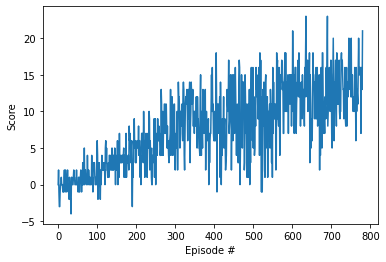

In [5]:
def dqn(n_episodes=1800, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    env_info = env.reset(train_mode=True)[brain_name]
    state_size = env_info.vector_observations.shape[1]
    nA:int = brain.vector_action_space_size

    agent = Agent(state_size=state_size, action_size=nA, seed=None)
    scores = []                         # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start     
    
    last_median = 0.0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]

        
        state = env_info.vector_observations[0] 
        score = 0
        neg_count = 0

        for t in range(max_t):
            action = agent.act(state, eps)        # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0] 

            print(f'Episode {i_episode} Step {t} Average Reward Window {np.average(scores_window):.2f} eps {eps:.2f}' , end='\r')
            agent.step(state, action, reward, next_state, done) 
            score += reward                                # update the score
            state = next_state                        # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break

        scores_window.append(score)              # save most recent score
        scores.append(score)                     # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if i_episode % 100 == 0:
            print(f'Episode {i_episode} Average Reward Window {np.average(scores_window):.2f} eps {eps:.2f}                     ')
        if np.average(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\nAverage Score: {:.2f}'.format(i_episode-100, np.average(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

As seen in the above image and output above, the environment is solved after 591 epsisodes and the agent's neural network is saved to ```checkpoint.pth``` file.

In [6]:
env.close()

#### Testing the trained DQN Agent

In order to see the trained agent interacting with the environment, it is necessary to enable the graphic output.

In [ ]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64", no_graphics=False)

The code below load the neural network weights into the agent and play with the environment. Note that the epsilon value is ```0.0```, so the agent does not explore the environment and exploit the trained policy to maximize expected reward.

In [ ]:

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

state_size = env_info.vector_observations.shape[1]
nA:int = brain.vector_action_space_size

agent_play = Agent(state_size=state_size, action_size=nA, seed=None)

agent_play.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

step = 0
while True:
    action = agent_play.act(state, 0.0)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    step += 1
    print(f'[{step}]Action {action} Reward {reward} ∑ Reward {score}', end='\r')	
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("\nTotal Score: {}".format(score))

In [ ]:
env.close()